# ph21: HWK 1
In this assignment, we will get Buoy data from the NDBC and then use it to make some estimates about the future.

### Familiarize yourself

We will be using data from the National Data Buoy Center (NDBC). Visit the NDBC website, https://www.ndbc.noaa.gov, and access some historical data. Take a look at the URL for the data you have accessed: you will need this format to access the data from python.

### Part 1: Getting the data

You will need to save all necessary for your second part here. The following steps are for reference.

1. Use the `requests` library (or any other similar library at your choice) to download historical Buoy data
3. Save all data you downloaded into (a) file(s). If you feel like it, only save that part that is relevant for your second part.
4. Use a html parser library (e.g., `BeautifulSoup`, `lxml`, or `html5lib`) to extract the meaning of the data (i.e. what is it measuring and what are the units?). Also save this information somewhere.
5. From now on, you don't need to make any more requests to the NDBC website. Only use the data you downloaded.


### Part 2: Processing the data
6. (Optional) use the `pandas` library to read the data and process as needed, and save the processed data if you want to. Save the processed data
7. plot the oceant temperatures (`WTMP`), wave heights (`WVHT`), average wave periods (`APD`), and wind speeds (`WSPD`) going back 10 years or so (some buoys don't have all the data every year)
8. Look through `scipy.stats` and choose something like Pearson's or Spearman's correlation test. Determine what (if any) correlations you find between mean ocean temperatures and maximum wave heights or wave periods.


### All written codes are only here for reference. You can also modify them if you want to.

# Part 1

In [126]:
from datetime import datetime
from io import StringIO
from pathlib import Path

from requests import Session

from bs4 import BeautifulSoup
from lxml import html

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mstats

import yaml
from tqdm import tqdm

In [128]:
# Prepare requests session. Let's pretend we are Chrome 118 here

# Think: In some cases, we can still be blocked as been flagged as bot at the first request.
#        Can you guess how the server knows it? (ignore javascript for now)

sess = Session()
sess.headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'})

# Think: What's the difference between using requests.get() and sess.get()?

In [130]:
# Where to save the fetched data
path = Path('./Data')
path.mkdir(exist_ok=True)
url_template = 'https://www.ndbc.noaa.gov/view_text_file.php?filename={buoy_id}h{year}.txt.gz&dir=data/historical/stdmet/'
description_page_url = 'https://www.ndbc.noaa.gov/faq/measdes.shtml'

In [132]:
# Load the config file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

buoy_ids:list[int] = config['buoys'] # We only use these id's for this assignment
columns:list[str] = config['columns'] # Data columns we want to keep.

To fetch one file, you can do something like this:

In [134]:
# An example of how to fetch the description and put it in a pd.DataFrame

r = sess.get(url_template.format(buoy_id=41010, year=2022))
r.raise_for_status()
buf= StringIO(r.text)
df = pd.read_csv(buf, sep=r'\s+', skiprows=[1])

Take a look:

In [136]:
df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2022,1,1,0,0,222,1.1,1.5,99.00,99.00,99.0,999,1019.6,24.9,25.2,20.6,99.0,99.0
1,2022,1,1,0,10,212,1.5,1.9,99.00,99.00,99.0,999,1019.7,24.9,25.2,20.5,99.0,99.0
2,2022,1,1,0,20,208,1.4,1.9,99.00,99.00,99.0,999,1019.6,24.9,25.2,20.4,99.0,99.0
3,2022,1,1,0,30,204,1.4,1.9,99.00,99.00,99.0,999,1019.7,24.9,25.2,20.5,99.0,99.0
4,2022,1,1,0,40,205,1.3,1.9,0.62,13.79,4.6,28,1019.8,24.9,25.1,20.6,99.0,99.0


Now, your task here is:
1. For each buoy_id, generate all urls pointing to its data, and fetch&save the data. If the data is missing (`status_code`=404), skip it.
2. Save everything in raw, or any processed form that you see fits.
3. If the file is already downloaded, don't download it again. Just skip it here.

Learn more about http status codes here:
- https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
- https://http.cat/

Two important ones here for today:
- 200: OK; everything's alright
- 404: Not Found; the file is missing

## Processing the data
First, we compile 10 years of data, from 2014 to 2023, for each of the buoys. We also process them in many ways, including concatenation of relevant years and filtering by saturated or incomplete data. For example, some buoys may not have data every year. Note that we wil preemptively complete most of the data processing in this step rather than later, just for convenience. Additionally, since we are adding all 10 years for every buoy into the 'Data' folder, this step may take a minute to run.

In [158]:
for buoy in buoy_ids:
    df_ten_years = pd.DataFrame()
    
    #compiling up to ten years of data into a concatenated dataframe.
    for yr in range(2014, 2024):
        r = sess.get(url_template.format(buoy_id=buoy, year=yr))
    
        #skipping years with missing data
        if(r.status_code == 404):
            continue
        buf = StringIO(r.text)
        df_year = pd.read_csv(buf, sep=r'\s+', skiprows=[1])
        df_ten_years = pd.concat([df_ten_years, df_year], axis=0)  
        
        # filtering data where any of the relevant columns has a value >= 90, or has NaN 
        df_filtered = df_ten_years[(df_ten_years[columns] < 90).all(axis=1)]
        df_filtered.dropna(subset=columns)
        
        # saving data to .csv files in the Data folder
        df_filtered.to_csv(path/f'filtered_buoy{buoy}.csv', index=False)

Though the units for all quantities are included in the data files received already, lets also try get them again from the website along with the description for each columns by parsing htmls.

All information of our interest is available at [`description_page`](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet).

Your task is to:

1. Get a dictionary of all the quantity name and its unit
2. Get a dictionary of all the quantity name and its description

To achieve this, you may want to use some html parser library, such as `BeautifulSoup`, `lxml`, or `html5lib`. If you really feel like it, you can also use regex just for fun like the good old days.

Tip: Having no idea where to start? Try to open the [`description_page`](https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet) in your browser, and use the `inspect` tool (F12, or Ctrl+Shift+I) to see how the html is structured and locate the part of your interest. Pasting a copy of the html to some LLM and ask it how to extract the information you want may also be a good idea.

Another Tip: Something called [`xpath`](https://en.wikipedia.org/wiki/XPath) may be extremely useful here. It can be access with `lxml`.

In [160]:
r = sess.get(description_page_url)
r.raise_for_status()
html_text = r.text # raw html text for your input

## Creating the Dictionaries
Now, we will create two dictionaries: one that maps quantities with units and another that maps quantites with its description. All are extracted from the description_page_url, https://www.ndbc.noaa.gov/faq/measdes.shtml. We will use the BeautifulSoup package for HTML parsing.

In [162]:
if not (path/'units.yaml').exists() or not (path/'meanings.yaml').exists():
    soup = BeautifulSoup(html_text, 'lxml')
    
    # For units, extract content from the <pre class="wide-layout"> tag, which was determined by inspecting the HTML on the website
    unit_html_lines = soup.find('pre', class_='wide-layout').get_text()

    # Due to the way the data is laid out, we take the first row as the quantities and the second row as the units
    unit_lines = unit_html_lines.splitlines()
    unit_lines = unit_lines[1:] #removing an empty line
    quantities = unit_lines[0].split()  # Split by spaces
    units = unit_lines[1].split()

    unit_map = dict(zip(quantities,units))

    # For meanings, first extract content from the <dl class="meas-des-glossary"> tag, which was determined by inspecting the HTML on the website.
    # Then, separate the quantities and meanings via their respective tags.
    meaning_html_lines = soup.find('dl', class_="meas-des-glossary")
    quantities = meaning_html_lines.find_all('dt', class_="meas-des-term")
    meanings = meaning_html_lines.find_all('dd', class_="meas-des-meaning")
    
    meaning_map = {}
    
    for quantity, meaning in zip(quantities, meanings):
        meaning_map[quantity.get_text()] = meaning.get_text().replace("\n"," ").replace("\t","") #remove new lines and tabs, and add to dictionary
        
    with open(path/'units.yaml', 'w') as f:
        yaml.dump(unit_map, f)
    with open(path/'meanings.yaml', 'w') as f:
        yaml.dump(meaning_map, f)

In [164]:
with open(path/'units.yaml') as f:
    unit_map = yaml.safe_load(f)
unit_map

{'#YY': '#yr',
 'APD': 'sec',
 'ATMP': 'degC',
 'DD': 'dy',
 'DEWP': 'degC',
 'DPD': 'sec',
 'GST': 'm/s',
 'MM': 'mo',
 'MWD': 'degT',
 'PRES': 'hPa',
 'PTDY': 'hPa',
 'TIDE': 'ft',
 'VIS': 'nmi',
 'WDIR': 'degT',
 'WSPD': 'm/s',
 'WTMP': 'degC',
 'WVHT': 'm',
 'hh': 'hr',
 'mm': 'mn'}

In [166]:
with open(path/'meanings.yaml') as f:
    meaning_map = yaml.safe_load(f)
meaning_map

{'APD': 'Average wave period (seconds) of all waves during the 20-minute period. See the Wave Measurements section.',
 'ATMP': 'Air temperature (Celsius).  For sensor heights on buoys, see Hull Descriptions.  For sensor heights at C-MAN stations, see C-MAN Sensor Locations',
 'DEWP': 'Dewpoint temperature taken at the same height as the air temperature measurement.',
 'DPD': 'Dominant wave period (seconds) is the period with the maximum wave energy. See the Wave Measurements section.',
 'GST': 'Peak 5 or 8 second gust speed (m/s) measured during the eight-minute or two-minute period.  The 5 or 8 second period can be determined by  payload, See the Sensor Reporting, Sampling, and Accuracy section.',
 'MWD': 'The direction from which the waves at the dominant period (DPD) are  coming. The units are degrees from true North, increasing clockwise, with  North as 0 (zero) degrees and East as 90 degrees.   See the Wave Measurements section.',
 'PRES': 'Sea level pressure (hPa).  For C-MAN sit

You may want to concatenate each buoy's data into a single dataframe, or any other data structure that you see fit. `pandas` is recommended here for your convenience.

After plotting, you will notice that some values are saturated at ~100. This is considered as artifacts, and should be removed. We will filter out everything $\ge 90$ in this case. If you are using `pandas`, you can do something like `df[df[columns] < 90]`.
Also, remove all rows with `NaN` values.

In [168]:
# This step was done above, when we initially preprocessed the data

As python handles datetime objects in fundamentally nasty way, we provide a snippet to convert YMDhm to datetime objects for you. You can use it like this:

```python
YMDhm = df[['#YY','MM','DD','hh','mm']]
timestemp = YMDhm.agg(lambda x: datetime(*x), axis=1)
```

to get a series of datetime objects from the dataframe `df` with columns `#YY`, `MM`, `DD`, `hh`, and `mm`.

#### For one buoy, plot all of its columns from all last 10 years. You can use any plotter of your choice.
##### Can you see any trend? If it is too noisy for human eyes, what could to be done to make it more clear?

## Analyzing the Data
Now, we will synthesize the data above and determine the relevant correlations. Due to the large volume of data, it is necessarily to downsample the data by a relatively large factor such that the trends and correlations can be more easily seen, without as much noise. Additionally, due to the relatively short nature of the period of wave heights (WVHT), wave periods (APD), and wind speeds (WSP), we plot only the data in the last year, 2023-2024. Due to some saturation of the data, there will appear some minor gaps in the graph of the ocean temperature (WTMP), particularly in some intervals from 2019-2021. We will also compute the Pearson correlation correlations between the data sets.

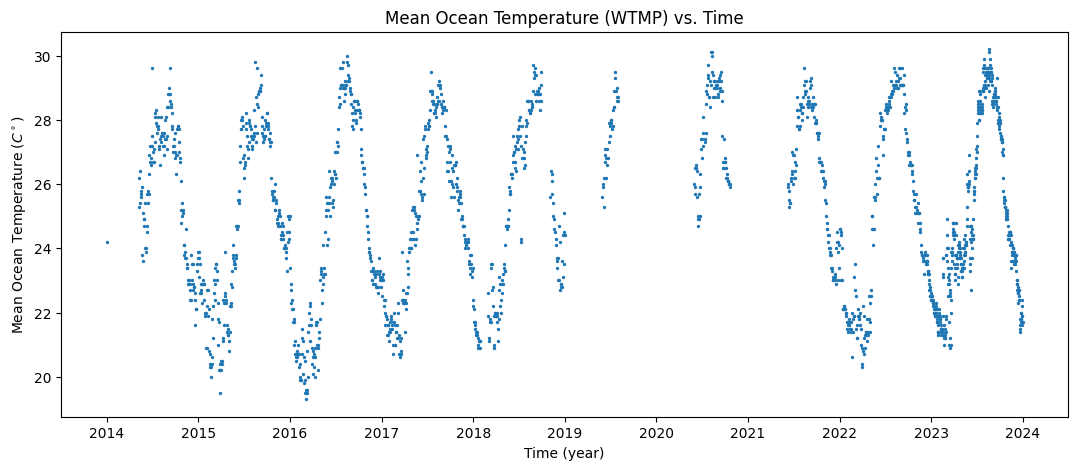

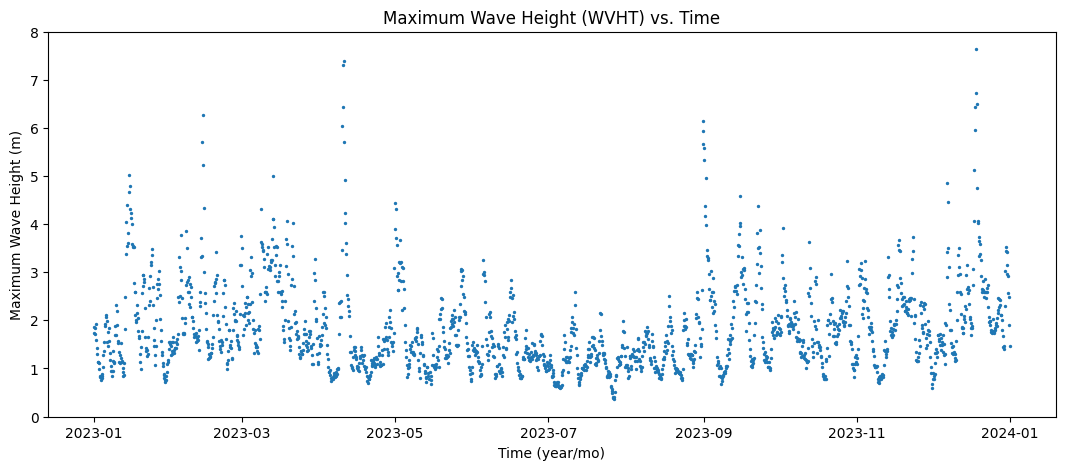

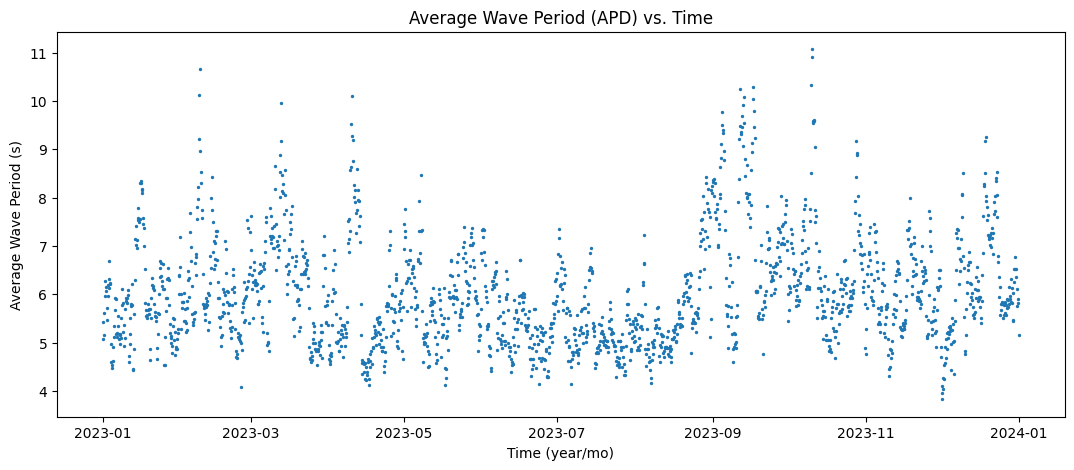

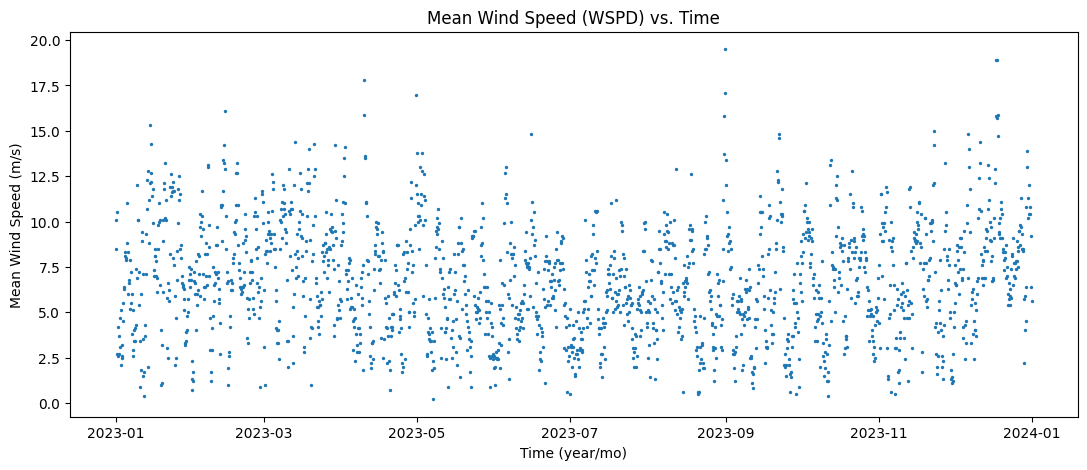

In [195]:
buoy41002 = pd.read_csv(path/"filtered_buoy41002.csv")

# Create a Pandas series consisting of the timestamps, to be used for plotting
YMDhm = buoy41002[['#YY','MM','DD','hh','mm']]
timestamp = YMDhm.agg(lambda x: datetime(*x), axis=1)

# Adding an additional column, and creating a new series for only the 2023 data.
buoy41002['timestamp'] = timestamp
data_2023 = buoy41002[buoy41002['timestamp'].dt.year == 2023]

# For the WTMP, downsample by a factor of 40 to make the data less noisy. This means that out of all the data, only every 40th point is plotted
downsample_ratio = 40
year_length = len(data_2023['timestamp'])
total_length = len(timestamp)

# In order to keep the density of points constant across all 4 graphs, we will multiply the downsample ratio for WVHT, APD, and WSDP by a factor of the 
# fraction defined below
fraction = year_length / total_length

# For WTMP, we plot all 10 years because it is easier to see the periodicity
plt.figure(figsize=(13,5))
plt.xlabel('Time (year)')
plt.ylabel(r'Mean Ocean Temperature ($C^\circ$)')
plt.title('Mean Ocean Temperature (WTMP) vs. Time')
WTMP_scatter = plt.scatter(timestamp[::downsample_ratio], buoy41002[columns[0]][::downsample_ratio], s=2, label=column)

# For the remaining three columns, we plot only the last year, from 2023-2024.
plt.figure(figsize=(13,5))
plt.xlabel('Time (year/mo)')
plt.ylabel('Maximum Wave Height (m)')
plt.title('Maximum Wave Height (WVHT) vs. Time')
WVHT_scatter = plt.scatter(data_2023['timestamp'][::int(downsample_ratio*fraction)], data_2023[columns[1]][::int(downsample_ratio*fraction)], s=2, label=column)

plt.figure(figsize=(13,5))
plt.xlabel('Time (year/mo)')
plt.ylabel('Average Wave Period (s)')
plt.title('Average Wave Period (APD) vs. Time')
APD_scatter = plt.scatter(data_2023['timestamp'][::int(downsample_ratio*fraction)], data_2023[columns[2]][::int(downsample_ratio*fraction)], s=2, label=column)

plt.figure(figsize=(13,5))
plt.xlabel('Time (year/mo)')
plt.ylabel('Mean Wind Speed (m/s)')
plt.title('Mean Wind Speed (WSPD) vs. Time')
WSPD_scatter = plt.scatter(data_2023['timestamp'][::int(downsample_ratio*fraction)], data_2023[columns[3]][::int(downsample_ratio*fraction)], s=2, label=column)
    

## Observations
From the data, we see that for the mean ocean temperature, there is a clear oscillatory nature in the graph. For the maximum wave height, the average wave period, and the mean wind speed, there appear to some be some oscillatory nature, but the trend is less clear and seems less periodic. Taken in the context of reality this makes sense: ocean temperatures vary rather predictably in a yearly fashion, and the other features, while also somewhat periodic, have more seasonal variation and have other factors that can impact them more dramatically.

##### Launch `scipy.stats` and choose something like Pearson's or Spearman's correlation test. Determine what (if any) correlations you find between mean ocean temperatures and maximum wave heights or wave periods.|

In [107]:
# Calculating and printing the Pearson correlation coefficient between ocean temperature and wave height, over all 10 years
print("Mean Ocean Temperatures (WTMP) vs. Maximum Wave Heights (WVHT)")
print("Correlation Coefficient: " + str(mstats.pearsonr(buoy41002['WTMP'], buoy41002['WVHT'])[0]))
print("P-Value: " + str(mstats.pearsonr(buoy41002['WTMP'], buoy41002['WVHT'])[1]))

Mean Ocean Temperatures (WTMP) vs. Maximum Wave Heights (WVHT)
Correlation Coefficient: -0.3345905033634179
P-Value: 0.0


In [109]:
# Calculating and printing the Pearson correlation coefficient between ocean temperature and wave period, over all 10 years
print("Mean Ocean Temperatures (WTMP) vs. Wave Periods (APD)")
print("Correlation Coefficient: " + str(mstats.pearsonr(buoy41002['WTMP'], buoy41002['APD'])[0]))
print("P-Value: " + str(mstats.pearsonr(buoy41002['WTMP'], buoy41002['APD'])[1]))

Mean Ocean Temperatures (WTMP) vs. Wave Periods (APD)
Correlation Coefficient: -0.12821589920968274
P-Value: 1.0644229992887296e-251


# Conclusions
For both Mean Ocean Temperature (WTMP) vs. Maximum Wave Heights (WVHT) and WTMP vs. Wave Periods (APD), there is a clear negative Pearson correlation. Despite the relatively modest seeming correlation coefficients ($|r|\approx 1/3$ or less), these are clearly statistically significant due to the large volume of data, as we can see from the p-values which are essentially zero. Thus, we conclude that ocean temperature and maximum wave heights/wave periods are statistically significantly correlated.